# Get the data and imports

In [1]:
!wget -nc https://lazyprogrammer.me/course_files/SPY.csv

File ‘SPY.csv’ already there; not retrieving.



In [86]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [87]:
df = pd.read_csv('SPY.csv', index_col='Date', parse_dates=True)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,112.370003,113.389999,111.510002,113.330002,92.246048,118944600
2010-01-05,113.260002,113.680000,112.849998,113.629997,92.490204,111579900
2010-01-06,113.519997,113.989998,113.430000,113.709999,92.555328,116074400
2010-01-07,113.500000,114.330002,113.180000,114.190002,92.946060,131091100
2010-01-08,113.889999,114.620003,113.660004,114.570000,93.255348,126402800


# Calculate the Rolling Slow and Fast Means with Random Selected Windows

In [97]:
df['logReturn'] = np.log(df['Close']).diff() # log return of the next day
df['logReturn'] = df['logReturn'].shift(-1) # shift the log return by 1 day
df['SlowSMA'] = df['Close'].rolling(30).mean() # 30-day simple moving average
df['FastSMA'] = df['Close'].rolling(10).mean() # 10-day simple moving average
df.head()

,Open,High,Low,Close,Adj Close,Volume,logReturn,SlowSMA,FastSMA,Signal,PrevSignal,Buy,Sell,IsInvested,AlgoLogReturn
Date,,,,,,,,,,,,,,,
2010-01-04,112.370003,113.389999,111.510002,113.330002,92.246048,118944600,0.002644,NaN,NaN,0,NaN,False,False,False,0.0
2010-01-05,113.260002,113.680000,112.849998,113.629997,92.490204,111579900,0.000704,NaN,NaN,0,0.0,False,False,False,0.0
2010-01-06,113.519997,113.989998,113.430000,113.709999,92.555328,116074400,0.004212,NaN,NaN,0,0.0,False,False,False,0.0
2010-01-07,113.500000,114.330002,113.180000,114.190002,92.946060,131091100,0.003322,NaN,NaN,0,0.0,False,False,False,0.0
2010-01-08,113.889999,114.620003,113.660004,114.570000,93.255348,126402800,0.001396,NaN,NaN,0,0.0,False,False,False,0.0


<AxesSubplot: xlabel='Date'>

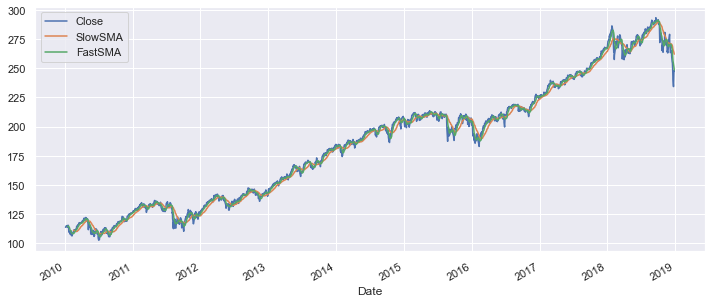

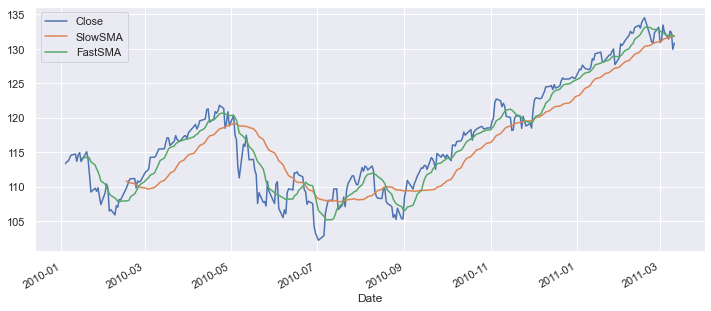

In [98]:
df[['Close', 'SlowSMA', 'FastSMA']].plot(figsize=(12, 5))
df[['Close', 'SlowSMA', 'FastSMA']].iloc[:300].plot(figsize=(12, 5))

In [99]:
# Determine the buy or sell signal based on the SMA crossover
df['Signal'] = np.where(df['FastSMA'] > df['SlowSMA'], 1, 0)

In [100]:
# shift the signal by 1 day to make the signal of the next day available today (for trading) 
df['PrevSignal'] = df['Signal'].shift(1)

In [101]:
df['Buy'] = ( (df['PrevSignal'] == 0) & (df['Signal'] == 1) ) # buy signal is when Fast < Slow and the next day Fast > Slow
df['Sell'] = ( (df['PrevSignal'] == 1) & (df['Signal'] == 0) ) # sell signal is when Fast > Slow and the next day Fast < Slow
# if the signal is the same, then we hold the position (no buy or sell)

In [102]:
# Write a function which determines for each step if we are invested or not

is_invested = False

def determine_invested(row):
    global is_invested
    if is_invested == True and row['Sell'] == True:
        is_invested = False
    if is_invested == False and row['Buy'] == True:
        is_invested = True

    # otherwise hold
    return is_invested
    
df['IsInvested'] = df.apply(determine_invested, axis=1)


In [103]:
df['AlgoLogReturn'] = df['IsInvested'] * df['logReturn'] # if we are invested, then we take the log return, otherwise 0

In [104]:
print('Algo log return: ', df['AlgoLogReturn'].sum())
print('Buy and hold log return: ', df['logReturn'].sum())

Algo log return:  0.3049019540291429
Buy and hold log return:  0.782116240308401


Thus, we can see that in this instance, the SMA trend following approach is performing worse than the buy-and-hold resul. 

In [105]:
# Calculate the standard deviation and sharp ratio of the log return and of the buy-and-hold strategy
# We assume the risk-free rate is 0 (no risk-free rate)

print('Algo log return standard deviation: ', df['AlgoLogReturn'].std())
print('Buy and hold log return standard deviation: ', df['logReturn'].std())

print('Algo sharp ratio: ', df['AlgoLogReturn'].mean() / df['AlgoLogReturn'].std())
print('Buy and hold sharp ratio: ', df['logReturn'].mean() / df['logReturn'].std())

Algo log return standard deviation:  0.006089880064170893
Buy and hold log return standard deviation:  0.00944697119316757
Algo sharp ratio:  0.022133947090060644
Buy and hold sharp ratio:  0.036600423640896725


Although we minimise risk, we also have a lower sharp ratio

# Searching for the Fast and Slow Hyperparams

In [119]:
df = pd.read_csv('SPY.csv', index_col='Date', parse_dates=True)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,112.370003,113.389999,111.510002,113.330002,92.246048,118944600
2010-01-05,113.260002,113.680000,112.849998,113.629997,92.490204,111579900
2010-01-06,113.519997,113.989998,113.430000,113.709999,92.555328,116074400
2010-01-07,113.500000,114.330002,113.180000,114.190002,92.946060,131091100
2010-01-08,113.889999,114.620003,113.660004,114.570000,93.255348,126402800


In [161]:
# Write a function which takes in fast and slow parameters and returns the Returns

Ntest = 1000 # number of tests

def determine_invested(row):
    global is_invested
    if is_invested == True and row['Sell'] == True:
        is_invested = False
    if is_invested == False and row['Buy'] == True:
        is_invested = True

    # otherwise hold
    return is_invested

def trendFollowing(df_input, fast_input, slow_input):
    
    global is_invested

    df_trend = df_input.copy()
    fast = fast_input
    slow = slow_input

    df_trend['logReturn'] = np.log(df_trend['Close']).diff() # log return of the next day
    df_trend['logReturn'] = df_trend['logReturn'].shift(-1) # shift the log return by 1 day

    df_trend['SlowSMA'] = df_trend['Close'].rolling(fast).mean() # 30-day simple moving average
    df_trend['FastSMA'] = df_trend['Close'].rolling(slow).mean() # 10-day simple moving average
    df_trend['Signal'] = np.where(df_trend['FastSMA'] > df_trend['SlowSMA'], 1, 0)
    df_trend['PrevSignal'] = df_trend['Signal'].shift(1)
    df_trend['Buy'] = ( (df_trend['PrevSignal'] == 0) & (df_trend['Signal'] == 1) ) # buy signal is when Fast < Slow and the next day Fast > Slow
    df_trend['Sell'] = ( (df_trend['PrevSignal'] == 1) & (df_trend['Signal'] == 0) ) # sell signal is when Fast > Slow and the next day Fast < Slow
    # if the signal is the same, then we hold the position (no buy or sell)

    # generate train and tet datasets
    # we split the data later because, when we calculate the SMA, the first values are missing until we have enough data
    # in the whole df, only the first few values are missing, meaning that only the train has missing values
    # if we split before, test will have missing values as well. In the real world, we have historical data for testing.
    train_trend = df_trend.iloc[:-Ntest]
    test_trend = df_trend.iloc[-Ntest:]

    train_idx = df.index <= train_trend.index[-1]
    test_idx = df.index > train_trend.index[-1]

    is_invested = False
    df_trend.loc[train_idx,'IsInvested'] = train_trend.apply(determine_invested, axis=1)
    df_trend.loc[train_idx,'AlgoLogReturn'] = df_trend.loc[train_idx,'IsInvested'] * train_trend['logReturn']

    is_invested = False
    df_trend.loc[test_idx,'IsInvested'] = test_trend.apply(determine_invested, axis=1)
    df_trend.loc[test_idx,'AlgoLogReturn'] = df_trend.loc[test_idx,'IsInvested'] * test_trend['logReturn']

    # We are not including the last value in the sum
    # The test set has no final return, because we shifted the values earlier. 
    # This has no effect on the test set, but it does on the train set. 
    # Thus, we are not including the last value in the sum.
    return (df_trend.loc[train_idx,'AlgoLogReturn'][:-1].sum(), 
            df_trend.loc[test_idx,'AlgoLogReturn'][:-1].sum(),
            df_trend.loc[train_idx,'AlgoLogReturn'][:-1].mean() / df_trend.loc[train_idx,'AlgoLogReturn'][:-1].std(),
            df_trend.loc[test_idx,'AlgoLogReturn'][:-1].mean() / df_trend.loc[test_idx,'AlgoLogReturn'][:-1].std(),
            df_trend)

In [151]:
# Test the function using the same parameters as before
xa = trendFollowing(df_input=df, fast_input = 30, slow_input = 10)
print('Train log return: ', xa[0])
print('Test log return: ', xa[1])
print('Sum of train and test log return: ', xa[0] + xa[1])
print('Sharp ratio of train: ', xa[2])
print('Sharp ratio of test: ', xa[3])

Train log return:  0.21371231572709082
Test log return:  0.09118963830205207
Sum of train and test log return:  0.3049019540291429
Sharp ratio of train:  0.02502140646646573
Sharp ratio of test:  0.01785327855638065


In [154]:
# Do a grid search to find the best fast and slow parameters
best_fast = None
best_slow = None
best_score = float('-inf')
for fast in range(2, 50):
    for slow in range(fast+5, 80):
        train, _, _, _, _ = trendFollowing(df_input = df, fast_input=fast, slow_input=slow)
        score = train
        if score > best_score:
            best_score = score
            best_fast = fast
            best_slow = slow

print('Best fast: ', best_fast)
print('Best slow: ', best_slow)
print('Return: ', trendFollowing(df_input = df, fast_input=best_fast, slow_input=best_slow))

Best fast:  25
Best slow:  31
Return:  (0.6646821100640965, 0.08152078090538417, 0.08066072495348259, 0.012805385080422354)


In [155]:
df['logReturn'] = np.log(df['Close']).diff() # log return of the next day
df['logReturn'] = df['logReturn'].shift(-1) # shift the log return by 1 day

train = df.iloc[:-Ntest].copy()
test = df.iloc[-Ntest:].copy()

# Total return buy-and-hold train
print('Buy and hold train log return: ', train['logReturn'][:-1].sum())
print('Sharp ratio buy-and-hold train: ', train['logReturn'][:-1].mean() / train['logReturn'][:-1].std())
# Total return buy-and-hold test
print('Buy and hold test log return: ', test['logReturn'][:-1].sum())
print('Sharp ratio buy-and-hold test: ', test['logReturn'][:-1].mean() / test['logReturn'][:-1].std())

print('---------')

# Total return trend following train
print('Trend following train log return: ', trendFollowing(df, best_fast, best_slow)[0])
print('Sharp ratio trend following train: ', trendFollowing(df, best_fast, best_slow)[2])
# Total return trend following test
print('Trend following test log return: ', trendFollowing(df, best_fast, best_slow)[1])
print('Sharp ratio trend following test: ', trendFollowing(df, best_fast, best_slow)[3])



Buy and hold train log return:  0.5970866514889401
Sharp ratio buy-and-hold train:  0.04709489772089021
Buy and hold test log return:  0.19307543946998518
Sharp ratio buy-and-hold test:  0.02238410638132544
---------
Trend following train log return:  0.6646821100640965
Sharp ratio trend following train:  0.08066072495348259
Trend following test log return:  0.08152078090538417
Sharp ratio trend following test:  0.012805385080422354


<AxesSubplot: xlabel='Date'>

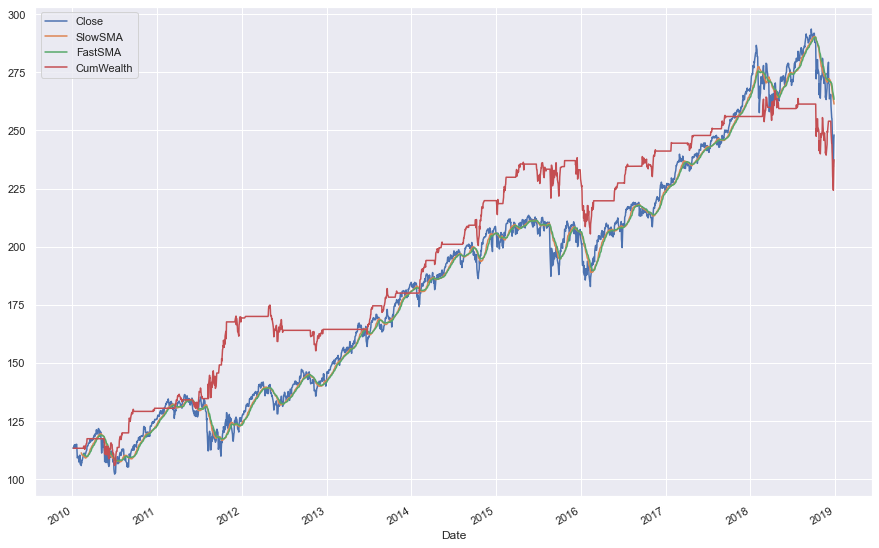

In [219]:
# Plot the Wealth Over Time
_, _, _, _, df_trend = trendFollowing(df_input = df, fast_input=best_fast, slow_input=best_slow)

df_trend = df_trend.iloc[:-1]

train_idx = df.index <= df_trend.index[-1]
test_idx = df.index > df_trend.index[-1]

df_trend['CumLogReturn'] = df_trend['AlgoLogReturn'].cumsum().shift(1)
df_trend['CumWealth'] = df_trend.iloc[0]['Close'] * np.exp(df_trend['CumLogReturn'].to_numpy(float))
df_trend[['Close', 'SlowSMA', 'FastSMA', 'CumWealth']].plot(figsize=(15, 10))

<AxesSubplot: xlabel='Date'>

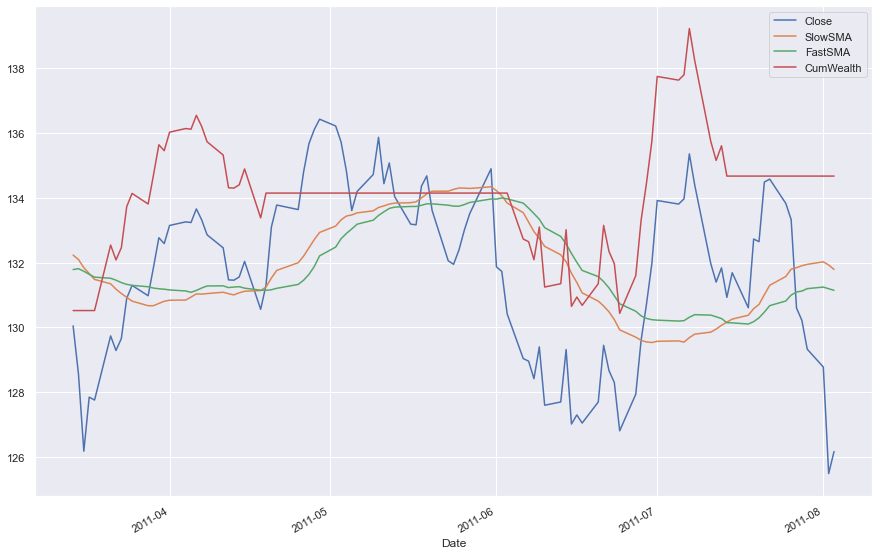

In [225]:
df_trend[['Close', 'SlowSMA', 'FastSMA', 'CumWealth']].iloc[300:400].plot(figsize=(15, 10))


<AxesSubplot: xlabel='Date'>

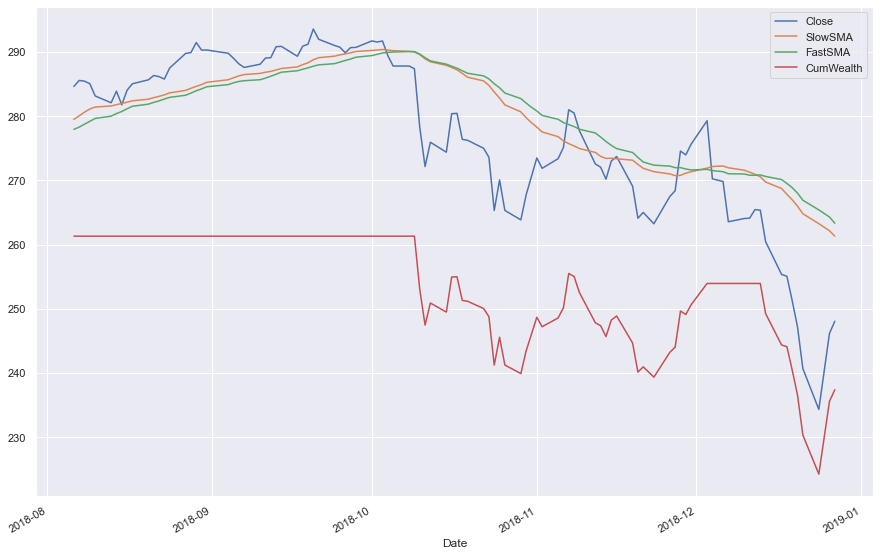

In [223]:
df_trend[['Close', 'SlowSMA', 'FastSMA', 'CumWealth']].iloc[-100:].plot(figsize=(15, 10))
